# Predicting Bankruptcy with Financial Data

In this project I look at financial data for companies listed on Taiwan's stock exchange between 1999 and 2009 and test a series of models that use this data to predict which companies are likely to go bankrupt. A model like this can help investors or fund managers to assess the risk of holding stock in a given company as well as the opportunities and risks of short selling a company's shares. This is purely an educational project so none of the recommendations in it should be construed as financial advice.

I'm going to be evaluating the performance of my models primarily based on the F1 scores for the bankruptcy class, since this number incorporates both:

1. What percentage of our bankruptcy predictions are correct (precision), and
2. What percentage of all bankruptcies our predictions account for (recall).

F1 is defined as:

    2 * precision * recall / (precision + recall)
    
In determining potential profits and losses from various investment strategies I'll be making two basic assumptions:

1. Bankruptcy reduces the value of a company's shares to zero.
2. The profit from shorting selling the shares of companies that go bankrupt is on average equal to the losses from short selling the shares of companies that don't go bankrupt.

The first assumption is realistic and allows us to calculate expected losses due to bankruptcy. For example, if we are able to predict non-bankruptcies with 99% precision at a certain probability threshold, then we can expect losses of 1%.

While the second assumption is unrealistic, it's useful because it means that if we are able to predict bankruptcies with >50% precision at a given probability threshold, then we can expect that profits will exceed losses if we short the shares of companies whose probability of bankruptcy falls above the threshold. In the real world, our model would have to use additional factors to determine expected profits and losses, but making this assumption is the best way to quantify the risk of shorting strategies given only the information available in our data set.

### Importing Libraries and Inspecting Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,\
classification_report, plot_confusion_matrix, precision_recall_curve

from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.ensemble import RandomForestClassifier

In [2]:
# inspecting the dataset
df = pd.read_csv('data/data.csv')
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [3]:
#looking for null or non-numeric values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

There are no null or non-numeric values.

Looking at the top of our dataframe, it appears that scaling may have already been done on the data. For example, the columns with ROA (return on assets) values include numbers that seem quite high, which suggests that the column has been min-max scaled. To investigate this question further we'll look at summary statistics for our columns.

#### Eliminating inconsistently scaled columns

In [4]:
df.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,...,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,...,0.807760,1.862942e+07,0.623915,0.607946,0.840402,0.280365,0.027541,0.565358,1.0,0.047578
std,0.176710,0.060686,0.065620,0.061595,0.016934,0.016916,0.013010,0.012869,0.013601,0.011163,...,0.040332,3.764501e+08,0.012290,0.016934,0.014523,0.014463,0.015668,0.013214,0.0,0.050014
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
25%,0.000000,0.476527,0.535543,0.527277,0.600445,0.600434,0.998969,0.797386,0.809312,0.303466,...,0.796750,9.036205e-04,0.623636,0.600443,0.840115,0.276944,0.026791,0.565158,1.0,0.024477
50%,0.000000,0.502706,0.559802,0.552278,0.605997,0.605976,0.999022,0.797464,0.809375,0.303525,...,0.810619,2.085213e-03,0.623879,0.605998,0.841179,0.278778,0.026808,0.565252,1.0,0.033798
75%,0.000000,0.535563,0.589157,0.584105,0.613914,0.613842,0.999095,0.797579,0.809469,0.303585,...,0.826455,5.269777e-03,0.624168,0.613913,0.842357,0.281449,0.026913,0.565725,1.0,0.052838
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,9.820000e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000


As we can see above, the max and min values for most columns are 0 and 1, which almost certainly means that these columns have been min-max scaled. Below we'll look at the summary statistics for the columns have not been min-max scaled (i.e. the columns with max values greater than 1). 

In [5]:
max_vals = df.describe().loc['max',:]
description = df[max_vals[max_vals !=1].index].describe().transpose()
description

,count,mean,std,min,25%,50%,75%,max
Operating Expense Rate,6819.0,1.995347e+09,3.237684e+09,0.0,1.566874e-04,2.777589e-04,4.145000e+09,9.990000e+09
Research and development expense rate,6819.0,1.950427e+09,2.598292e+09,0.0,1.281880e-04,5.090000e+08,3.450000e+09,9.980000e+09
Interest-bearing debt interest rate,6819.0,1.644801e+07,1.082750e+08,0.0,2.030203e-04,3.210321e-04,5.325533e-04,9.900000e+08
Revenue Per Share (Yuan ¥),6819.0,1.328641e+06,5.170709e+07,0.0,1.563138e-02,2.737571e-02,4.635722e-02,3.020000e+09
Total Asset Growth Rate,6819.0,5.508097e+09,2.897718e+09,0.0,4.860000e+09,6.400000e+09,7.390000e+09,9.990000e+09
Net Value Growth Rate,6819.0,1.566212e+06,1.141594e+08,0.0,4.409689e-04,4.619555e-04,4.993621e-04,9.330000e+09
Current Ratio,6819.0,4.032850e+05,3.330216e+07,0.0,7.555047e-03,1.058717e-02,1.626953e-02,2.750000e+09
Quick Ratio,6819.0,8.376595e+06,2.446847e+08,0.0,4.725903e-03,7.412472e-03,1.224911e-02,9.230000e+09
Total debt/Total net worth,6819.0,4.416337e+06,1.684069e+08,0.0,3.007049e-03,5.546284e-03,9.273293e-03,9.940000e+09
Accounts Receivable Turnover,6819.0,1.278971e+07,2.782598e+08,0.0,7.101336e-04,9.678107e-04,1.454759e-03,9.740000e+09


In almost all these cases, the max values are close to 10 billion, while median values are below 1. This suggests that data for these columns may be inconsistently scaled. There are two possible solutions. We could drop rows for high values or we could drop columns. The problem with dropping rows is that we would be biasing our data set against high values, thereby distorting our results. For this reason, I'll instead be dropping columns that haven't been min-max scaled.

In [6]:
df = df.drop(max_vals[max_vals !=1].index, axis=1)

#### Inspecting target variable distribution

In [7]:
# checking target variable distribution
df['Bankrupt?'].value_counts()

0    6599
1     220
Name: Bankrupt?, dtype: int64

In [8]:
# normalized target variable distribution
df['Bankrupt?'].value_counts(normalize=True)

0    0.967737
1    0.032263
Name: Bankrupt?, dtype: float64

As we can see, the data set is highly imbalanced -- only 3% of companies represented went bankrupt. This means that we could easily get a 97% accuracy score by predicting that no companies went bankrupt. However, this would also yield an undefined precision and a 0% recall for predicting bankruptcies.

### Eliminating Perfectly Correlated Variables

In [9]:
#looking for collinearity of predictive variables
# code from https://github.com/learn-co-curriculum/dsc-multicollinearity-of-features
predictors = df.drop('Bankrupt?', axis=1)

predictor=predictors.corr().abs().stack().reset_index().sort_values(0, ascending=False)

predictor['pairs'] = list(zip(predictor.level_0, predictor.level_1))
predictor.set_index(['pairs'], inplace = True)
predictor.drop(columns=['level_1', 'level_0'], inplace = True)
predictor.columns = ['correlations']
predictor.drop_duplicates(inplace=True)

predictor[(predictor['correlations']<1)&(predictor['correlations']>=0.99)]

,correlations
pairs,
"( Debt ratio %, Net worth/Assets)",1.000000
"( Gross Profit to Sales, Operating Gross Margin)",1.000000
"( Net Value Per Share (C), Net Value Per Share (A))",0.999837
"( Realized Sales Gross Margin, Operating Gross Margin)",0.999518
"( Realized Sales Gross Margin, Gross Profit to Sales)",0.999518
"( Net Value Per Share (A), Net Value Per Share (B))",0.999342
"( Net Value Per Share (B), Net Value Per Share (C))",0.999179
"( Operating Profit Per Share (Yuan ¥), Operating profit/Paid-in capital)",0.998696
"( After-tax Net Profit Growth Rate, Regular Net Profit Growth Rate)",0.996186


Because we'll be using regularization for feature selection, we don't need to be aggressive in paring down features at this point. However, the top two pairs are perfectly correlated because they correspond to the accounting identity:

Debt ratio % = 1 - Net worth/Assets 

and the definitional identity

Gross Profit to Sales = Operating Gross Margin

So there's no possible reason why we would want to keep them. It's possible that some of the differences between the other features may be important for future models so we'll leave them in.

In [10]:
## Eliminating perfectly correlated variables

df = df.drop([' Debt ratio %', ' Gross Profit to Sales'], axis=1)

### Splitting Data

In [11]:
#splitting predictor and target variables

y= df['Bankrupt?']
X = df.drop('Bankrupt?', axis=1)

In [12]:
#splitting data into training set and testing set

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Baseline Model: Decision Tree Classifier #1

We'll now fit a simple decision tree classifier on our model, using GridSearchCV to tune our hyper-parameters. I'm choosing low tree depths to generate a simple, interpretable model that won't overfit on the data. I'm leaving out leaf size specifications from the grid search since the classes are imbalanced and I want the model to be able to pick out smaller leaf sizes if necessary.

In [13]:
tree = DecisionTreeClassifier(random_state=42, class_weight='balanced')

grid = [{'criterion': ['gini', 'entropy'],
         'max_depth': [2, 3, 4]
        }]
gs_tree = GridSearchCV(estimator=tree, param_grid=grid, scoring='f1', cv=5)

In [14]:
gs_tree.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=42),
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_depth': [2, 3, 4]}],
             scoring='f1')

In [15]:
gs_tree.best_params_

{'criterion': 'entropy', 'max_depth': 2}

#### Decision Tree #1 Results - Training Data

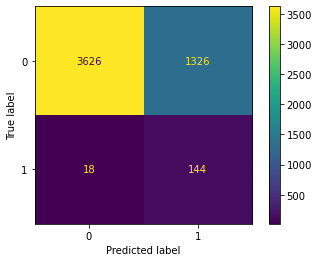

In [16]:
plot_confusion_matrix(gs_tree, X_train, y_train)
plt.show()

In [17]:
y_pred = gs_tree.predict(X_train)

print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.73      0.84      4952
           1       0.10      0.89      0.18       162

    accuracy                           0.74      5114
   macro avg       0.55      0.81      0.51      5114
weighted avg       0.97      0.74      0.82      5114



#### Decision Tree #1 Results - Testing Data

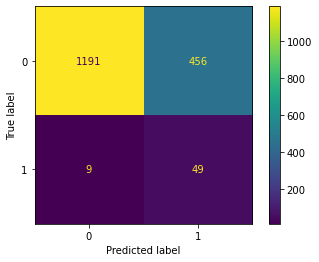

In [18]:
plot_confusion_matrix(gs_tree, X_test, y_test)
plt.savefig('images/dt1_confusion.png')
plt.show()

In [19]:
y_pred = gs_tree.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.72      0.84      1647
           1       0.10      0.84      0.17        58

    accuracy                           0.73      1705
   macro avg       0.54      0.78      0.51      1705
weighted avg       0.96      0.73      0.81      1705



### Interpreting Decision Tree #1

While the recall for this model is excellent (84%), the precision is only 10% and the f1-score is only 0.17.

This is a very crude model that does a good job picking out most companies that do go bankrupt, but also includes an even larger number of companies that don't go bankrupt. It's most useful for investors who want to avoid risky assets while putting the minimum possible effort into portfolio management. And on the test data it worked quite well for this purpose. While someone who invests randomly can expect losses of over 3% due to bankruptcies, investors who use this simple decision tree can expect to trim losses due to bankruptcies to only 1%, meaning that it performed about as well as Logistic Regression for this purpose. 

In the tree below, we see that the data has been filtered into four bins, the two bins on the right predicting values of 0 (no bankruptcy) and the two bins on the left predicting values of 1 (bankruptcy). Our decision tree tells us how values ended up in each of these bins, as well as the entropy of each of the bins. An entropy value of one means that the bin is evenly divided between bankruptcies and non-bankruptcies, while an entropy of zero means that the bin consists of only bankruptcies or non-bankruptcies.

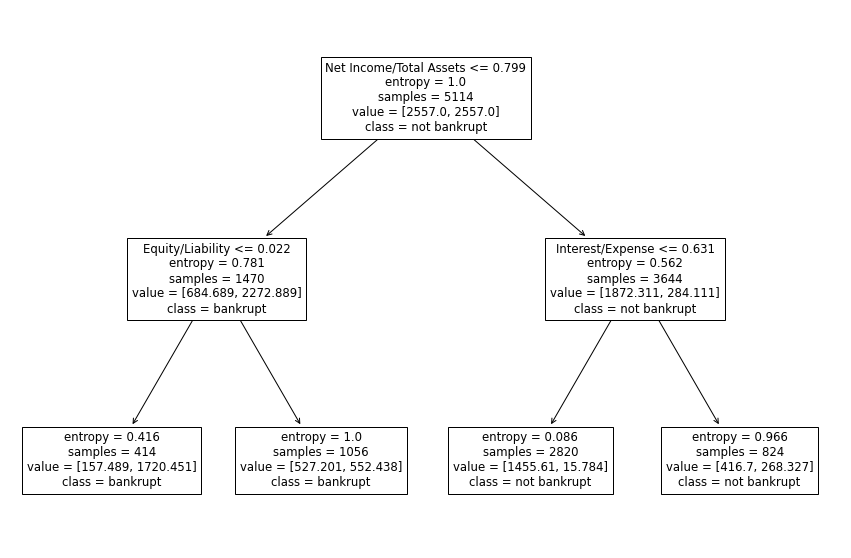

In [20]:
fig, ax = plt.subplots(figsize=(15, 10))
plot_tree(gs_tree.best_estimator_, feature_names = {61: 'Net Income/Total Assets', 68: 'Equity/Liability', 26: 'Interest/Expense'}, class_names = {0: 'not bankrupt', 1: 'bankrupt'})
plt.savefig('images/dt1_tree.png')
plt.show()

Below we can see the three features used in our decision tree, along with their relative importance.

In [21]:
features = pd.concat([pd.DataFrame(X.columns, columns=['column']), pd.DataFrame(gs_tree.best_estimator_.feature_importances_, columns=['importance'])], axis=1)
features.sort_values('importance', ascending=False).head()

,column,importance
61,Net Income to Total Assets,0.645758
68,Equity to Liability,0.182021
26,Interest Expense Ratio,0.172221
49,Total expense/Assets,0.000000
48,Total income/Total expense,0.000000


The top node divides the data between companies with higher net income to total assets ratios and companies with lower net income to total assets ratios, with lower ratios all labeled as bankruptcies and higher ratios all labeled as non-bankruptcies. While this model sweeps up 28% of non-bankruptcies leading to its very low (10%) precision rate, it has a recall of 84%, which is unsurprising since a company with poor financial health is very likely to have a below average income relative to its size. We can see this from the histograms below, which shows 84% of bankrupt companies falling to the left of the the red line and 28% of non-bankrupt companies falling to the left of the red line.

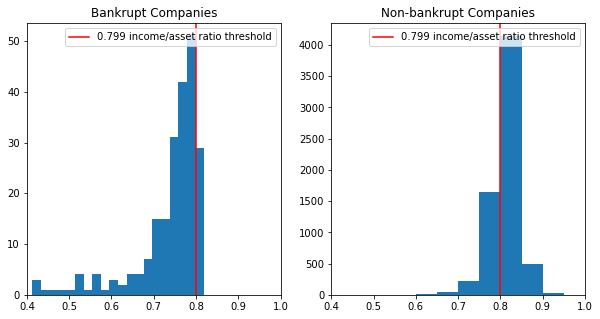

In [22]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

ax1.hist(df.loc[df['Bankrupt?']==1][' Net Income to Total Assets'], bins=20)
ax1.axvline(x=0.799, color='red', label='0.799 income/asset ratio threshold')
ax1.set_title('Bankrupt Companies')
ax1.set_xlim(0.4, 1)
ax1.legend()

ax2.hist(df.loc[df['Bankrupt?']==0][' Net Income to Total Assets'], bins=20)
ax2.axvline(x=0.799, color='red', label='0.799 income/asset ratio threshold')
ax2.set_title('Non-bankrupt Companies')
ax2.set_xlim(0.4, 1)
ax2.legend()
plt.savefig('images/dt1_hist.png')
plt.show()

The next splits in our decision tree divide each of the net income/total assets nodes into two leaves--a high entropy leaf and a low entropy leaf. These leaves don't have any effect on the decision made by the algorithm. But their  entropy tells us how confident the algorithm is in its predictions. The leaves with entropy levels of 1 and 0.966 include companies that have about the same likelihood of representing bankruptcies as non-bankruptcies, while the leaves with lower entropy levels (0.416 and 0.086) represent a significantly greater likelihood of either bankruptcies or non-bankruptcies.

### Decision Tree #1: First five rows

Below we can see the relevant statistics for the first five rows of test data as well as the predictions made by the decision tree algorithm using these statistics.

In [23]:
stats = X_test.iloc[:5, [61, 68, 26]]
index_rows = list(X_test.iloc[:5, :].index)
predictions = pd.DataFrame(gs_tree.predict(X_test.iloc[:5,:]), columns=['predictions'], index=index_rows)
values = pd.DataFrame(y_test).iloc[:5,:]
probabilities = pd.DataFrame([n[1] for n in gs_tree.predict_proba(X_test.iloc[:5,:])], columns=['probabilities'], index=index_rows)
pd.concat([stats, probabilities, predictions, values], axis=1)

,Net Income to Total Assets,Equity to Liability,Interest Expense Ratio,probabilities,predictions,Bankrupt?
239,0.765336,0.087378,0.630611,0.511688,1,0
2850,0.817797,0.028519,0.631052,0.010727,0,0
2687,0.847518,0.048876,0.630615,0.010727,0,0
6500,0.767650,0.014691,0.630033,0.916137,1,1
2684,0.810394,0.019245,0.632175,0.391703,0,0


In the first five rows there is one true positive and one false positive. Both these companies have a low net income to assets ratio which is why both of them are labeled as bankrupt. However, the true positive is labeled as bankrupt with a 91.6% probability, while the false positive was labeled as bankrupt with only a 51.2% probability. This is because the company with a 91.6% bankruptcy probability had a scaled equity to liability ratio of 0.015 (lower than the the 0.022 threshold), while the company with a 51.2% bankruptcy probability had a equity to liability ratio of 0.087, which is significantly higher than the threshold. In other words, the more indebted company was labeled as having a much greater probability of going bankrupt, while the less indebted company was given about 51% probability of bankruptcy.

### Decision Tree #1: Probability Thresholds

Since the decision tree produces four probability values, we can evaluate our model's performance separately for predictions made at each of these probability thresholds. We already saw how the model performed using the 51% threshold to predict bankruptcies. We'll now look at two of the three other thresholds - 91.6% and 1.5% - to evaluate their usefulness for our stakeholders.

#### Precision of Decision Tree #1 at 91.6% probability threshold

Below we can see how the leaf with a 91.6% probability prediction yielded 107 false positives and only 39 true positives.

In [24]:
def get_threshold_outcome_dataframe(model):
    y_probs = [n[1] for n in model.predict_proba(X_test)]

    probs_df = pd.DataFrame(y_probs, index=list(y_test.index), columns=['probabilities'])
    y_preds_df = pd.DataFrame(gs_tree.predict(X_test), index=list(y_test.index), columns=['predictions'])
    y_true_df = pd.DataFrame(y_test)
    dataframe = pd.concat([probs_df, y_preds_df, y_true_df], axis=1)
    return dataframe

def get_indices_at_threshold(model, threshold, above_thresh=True):
    dataframe = get_threshold_outcome_dataframe(model)
    if above_thresh==True:
        return list(dataframe[dataframe['probabilities']>threshold].index)
    else:
        return list(dataframe[dataframe['probabilities']<=threshold].index)


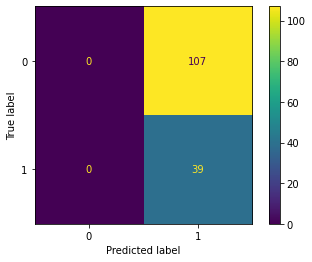

In [25]:
high_threshold=get_indices_at_threshold(gs_tree, 0.9, above_thresh=True)
plot_confusion_matrix(gs_tree, X_test.loc[high_threshold,:], y_test[high_threshold])
plt.show()

#### Performance of Decision Tree at 1.5% probability threshold

On the other had, the leaf with a 1.5% probability prediction yielded 0 false negatives.

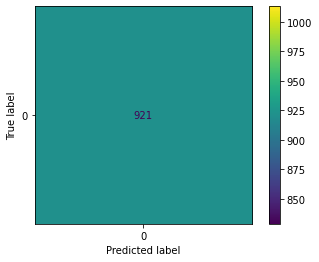

In [26]:
low_threshold=get_indices_at_threshold(gs_tree, 0.015, above_thresh=False)

plot_confusion_matrix(gs_tree, X_test.loc[low_threshold,:], y_test[low_threshold])
plt.show()

While this Decision Tree works well for picking out safe investments, it's very bad at predicting bankruptcies. In fact, companies with a predicted 91.6% probability of bankruptcy are in fact almost three times as likely not to go bankrupt as to go bankrupt. If we we shorted every stock above the 91.6% threshold, we would expect our losses to exceed our profits.

## Logistic Regression

I'll next build a linear regression model, using gridsearch to choose between Lasso and Ridge regression and to tune the regularization parameter C. I'm including a standard scaler in the pipeline, which will allow us to interpret feature effects in terms of z-scores. I'm also balancing the weight of the classes so that the model won't be biased towards predicting the majority class. 

In [27]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('logreg', LogisticRegression(class_weight='balanced', solver='liblinear', max_iter=500, random_state=42))])

grid = [{'logreg__penalty': ['l1', 'l2'],
         'logreg__C': [np.e**i for i in range(-2, 3)],
        }]

gs_logreg = GridSearchCV(estimator=pipe,
                         param_grid=grid,
                         scoring='f1',
                         cv=5)

In [28]:
gs_logreg.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logreg',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=500,
                                                           random_state=42,
                                                           solver='liblinear'))]),
             param_grid=[{'logreg__C': [0.1353352832366127, 0.36787944117144233,
                                        1.0, 2.718281828459045,
                                        7.3890560989306495],
                          'logreg__penalty': ['l1', 'l2']}],
             scoring='f1')

### Regularization of Logistic Regression Model

Below we see that GridSearch selected Lasso (L1) Regularization, with a regularization hyper-parameter of e^-1. In the next cell, we see that regularization trimmed 21 features from the model by bringing their coefficients down to zero.

In [29]:
gs_logreg.best_params_

{'logreg__C': 0.36787944117144233, 'logreg__penalty': 'l1'}

In [30]:
coefs = pd.DataFrame(gs_logreg.best_estimator_.steps[1][1].coef_, columns=X.columns)
coefs = coefs.transpose()
coefs.rename(columns={0:'coefficient'}, inplace=True)
coefs['|coefficient|']=coefs['coefficient'].abs()
coefs[coefs['coefficient']==0].shape[0]

21

And here we can see the five largest coefficients in our model by absolute value.

In [31]:
coefs.sort_values('|coefficient|', ascending=False).head()

,coefficient,|coefficient|
Persistent EPS in the Last Four Seasons,-2.136638,2.136638
Operating profit/Paid-in capital,1.864492,1.864492
Net worth/Assets,-1.638927,1.638927
Borrowing dependency,1.370497,1.370497
Inventory and accounts receivable/Net value,-0.910537,0.910537


As we might expect in the two cases where our coefficients are negative (the two plots on the left) the variable's values are significantly higher for the non-bankruptcy class than for the bankruptcy class.

Interestingly, even though the coefficient for Operating profit/paid-in capital is positive, the quartiles and max values seem to be higher for the non-bankruptcy class than for the bankruptcy class.

Finally, as might be expected, borrowing dependency values are on average higher for the bankruptcy class than for the non-bankruptcy class.

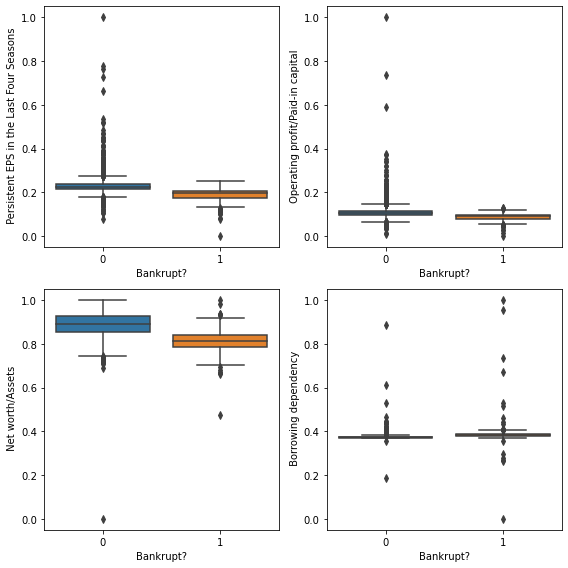

In [32]:
import seaborn as sns

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(8, 8), tight_layout=True)

sns.boxplot(x=df['Bankrupt?'], y=df[' Persistent EPS in the Last Four Seasons'], ax=ax1)
sns.boxplot(x=df['Bankrupt?'], y=df[' Operating profit/Paid-in capital'], ax=ax2)
sns.boxplot(x=df['Bankrupt?'], y=df[' Net worth/Assets'], ax=ax3)
sns.boxplot(x=df['Bankrupt?'], y=df[' Borrowing dependency'], ax=ax4)
plt.savefig('images/logreg_boxplot.png')
plt.show()

### Performance of Logistic Regression Model

Below are the confusion matrices and classification reports for our Logistic Regression Model. While there is a 10% drop in bankruptcy recall from the training set to the testing set, the f1 score drops by only 3% and the precision by only 2%, which suggests that the model hasn't been significantly overfit.

#### Logistic Regression Training Results

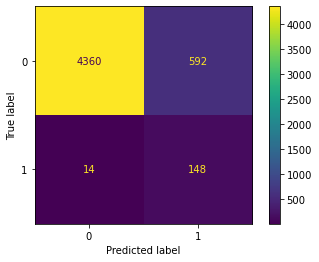

In [33]:
plot_confusion_matrix(gs_logreg, X_train, y_train)

In [34]:
y_pred = gs_logreg.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.88      0.94      4952
           1       0.20      0.91      0.33       162

    accuracy                           0.88      5114
   macro avg       0.60      0.90      0.63      5114
weighted avg       0.97      0.88      0.92      5114



#### Logistic Regression Testing Results

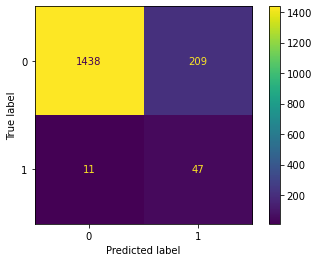

In [35]:
plot_confusion_matrix(gs_logreg, X_test, y_test)
plt.savefig('images/logreg_confusion.png')
plt.show()

In [36]:
y_pred = gs_logreg.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.87      0.93      1647
           1       0.18      0.81      0.30        58

    accuracy                           0.87      1705
   macro avg       0.59      0.84      0.61      1705
weighted avg       0.96      0.87      0.91      1705



###  The Precision Recall Curve

Since finance is inherently based on quantifying uncertainty, imperfect results shouldn't necessarily be discouraging. Our model's decision function is based on a 50% probability threshold but we can easily change this threshold if we want to adjust the balance between precision and recall. 

Below we look at confusion matrices for three other probability thresholds:

- 99.9% probability of bankruptcy
- 95% probability of bankruptcy - the probability threshold for which our precision is above which we predict bankruptcies with 50% precision
- 12% probability of bankruptcy - the point of maximum recall for both bankruptcies and non-bankruptcies.

We then plot the trade-off between precision and recall and while indicating the place of each of these thresholds on the curve.

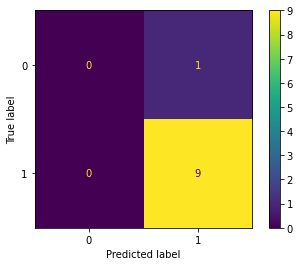

In [37]:
# confusion matrix using high threshold
high_threshold=get_indices_at_threshold(gs_logreg, 0.999)
plot_confusion_matrix(gs_logreg, X_test.loc[high_threshold,:], y_test[high_threshold])
plt.show()

In [38]:
def get_precision_recall_df(model):
#getting probabilities for decision function

    y_probs = [n[1] for n in model.predict_proba(X_test)]

# getting precision recall curve

    precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# creating a dataframe to for precision recall tradeoff

    thresholds_df = pd.DataFrame(thresholds.reshape(-1,1), columns=['thresholds'])
    precision_df = pd.DataFrame(precision.reshape(-1,1), columns=['precision'])
    recall_df = pd.DataFrame(recall.reshape(-1,1), columns=['recall'])

    return pd.concat([thresholds_df, recall_df, precision_df], axis=1)

In [39]:
# finding threshold that results in 50% precision
precision_recall_df=get_precision_recall_df(gs_logreg)
precision_recall_df.loc[(precision_recall_df['precision']>0.499)&(precision_recall_df['precision']<0.501)]

,thresholds,recall,precision
1655,0.943600,0.413793,0.5
1659,0.951774,0.379310,0.5
1661,0.954154,0.362069,0.5


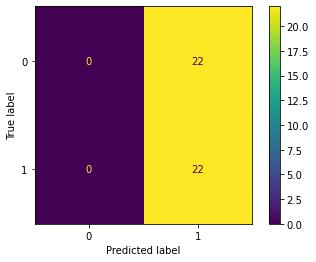

In [40]:
# 50% precision threshold

threshold_95=get_indices_at_threshold(gs_logreg, 0.95)
plot_confusion_matrix(gs_logreg, X_test.loc[threshold_95,:], y_test[threshold_95])
plt.show()

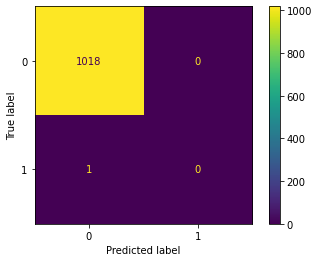

In [41]:
#confusion matrix using low threshold (high recall)

# confusion matrix using high threshold
low_threshold=get_indices_at_threshold(gs_logreg, 0.12, above_thresh=False)
plot_confusion_matrix(gs_logreg, X_test.loc[low_threshold,:], y_test[low_threshold])
plt.show()

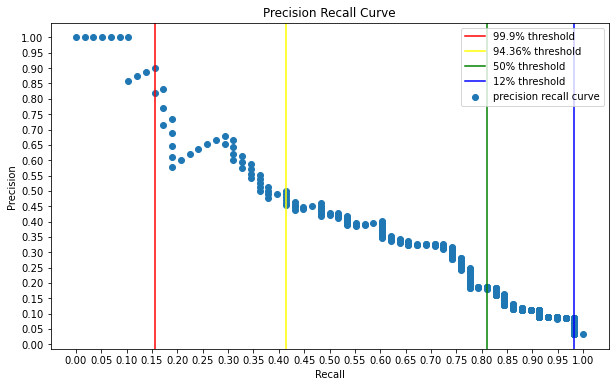

In [42]:
y_probs = [n[1] for n in gs_logreg.predict_proba(X_test)]

precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(recall, precision, label='precision recall curve')

ax.set_yticks([i/20.0 for i in range(21)])
ax.set_xticks([i/20.0 for i in range(21)])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision Recall Curve')
ax.axvline(x=9/58, label='99.9% threshold', color='red')
ax.axvline(x=0.413793, label='94.36% threshold', color='yellow')
ax.axvline(x=0.81, label='50% threshold', color='green')
ax.axvline(x=57/58, label='12% threshold', color='blue')
plt.legend(loc='upper right')
plt.savefig('images/logreg_curve.png')
plt.show()

These four lines correspond to the following investment strategies.

##### Blue: Below threshold, go long

The blue line on the right (12% predicted probability of bankruptcy) represent the most conservative decision threshold. If we had guessed that every company above the 12% threshold would go bankrupt, around 90% of the companies we labeled as bankrupt would have been false positives, but we would have also succeeded at finding all but one bankrupt company. Out of the 1019 companies in this category, only one would have gone bankrupt or 0.1%.

##### Red: Above threshold, go short

The red line on the left is also a conservative threshold (99.9% probability of bankruptcy), since 9 out of the 10 companies in the test set that had a bankruptcy probability above 99.9% did in fact go bankrupt. While it's likely that the market is already bearish on these stocks and that this bearishness is already a part of our model, bankruptcy likely reduced their value to zero, meaning that investors may have been able to profit from shorting these stocks before they reached that point. 

##### Yellow: Below threshold, don't go short

The yellow line represents the point at which our decision function yielded the same number of true positives and false positives in its bankruptcy predictions--22 of each. This takes places when we set our probability threshold at 95%. Assuming that this is the only information we have, we shouldn't short stocks of companies that have less than 95% chance of bankruptcy, since below this threshold, we can expect every gain to be offset by a loss.

##### Green: Above threshold, don't go long

The green line represents the decision function using a 50% probability threshold, which is what we evaluated in our original confusion matrix and classification report. This probability threshold is most useful to investors who are trying to balance opportunity with risk exposure. Investors who own a representative selection of stocks below this threshold are likely to see a 1% loss due to bankruptcies (as opposed to 3% from fully random investments and 0.1% from a conservative strategy), but may also see substantial returns from their willingness to go long on other stocks in this category.

### Logistic Regression Test Cases: First Five Rows of Data

Let's see the accuracy of this model's predictions on the first five rows of the testing set.

In [43]:
get_threshold_outcome_dataframe(gs_logreg).head()

,probabilities,predictions,Bankrupt?
239,0.052569,1,0
2850,0.127949,0,0
2687,0.005546,0,0
6500,0.943760,1,1
2684,0.620825,0,0


As we see above, out of the first five predictions in our test set, we have three true negatives, one true positive, and one false positive. In the case of the false positive (Row 4), our decision function gave 62% probability that this company would go bankrupt, so it's unsurprising that this guess turned out to be wrong, since we would expect predictions with this probability to be wrong in one out of three cases. On the other hand, the bankruptcy probability was 94% for Row 3, so it's not surprising that this prediction turned out to be correct, since we expect predictions with this probability to be wrong in only 6 out of 100 cases.

Next, we'll look at both the true positive (the company that did go bankrupt) and false positive (the company that didn't) in closer detail.

#### Function for getting top probability factors per row

In [44]:
def get_probability_factor_table(row):
    
    #comparing data for the true positive with summary statistics
    comparison = pd.concat([X_test.iloc[row,:], X.mean(), X.std()], axis=1) 
    
    # renaming columns
    comparison.rename(columns={X_test.iloc[row,:].name: 'sample', 0: 'mean', 1: 'std'}, inplace=True) 
    
    #engineering z-scores
    comparison['z_score'] = ((comparison['sample'] - comparison['mean'])/comparison['std']) 
    
    #merging with model coefficients dataframe
    comparison = comparison.merge(coefs, how='inner', left_on=comparison.index, right_on=coefs.index) 
    
    # dropping absolute value
    comparison = comparison.drop('|coefficient|', axis=1) 
       
    #calculating probability factor for each coefficient
    comparison['probability factor'] = np.e**(comparison['z_score']*comparison['coefficient']) 
    
    #renaming first column 'feature'
    comparison.rename(columns={'key_0': 'feature'}, inplace=True)
    
    #return top of data frame
    return comparison.sort_values(by='probability factor', ascending=False).head()
    

#### Test Case 1: The True Positive

In [45]:
get_probability_factor_table(3)

,feature,sample,mean,std,z_score,coefficient,probability factor
27,Net worth/Assets,0.772682,0.886823,0.053920,-2.116846,-1.638927,32.116041
15,Persistent EPS in the Last Four Seasons,0.189279,0.228813,0.033263,-1.188549,-2.136638,12.673299
29,Borrowing dependency,0.393783,0.374654,0.016286,1.174512,1.370497,5.001135
61,Net Income to Total Assets,0.767650,0.807760,0.040332,-0.994496,-0.860077,2.352182
0,ROA(C) before interest and depreciation befor...,0.436942,0.505180,0.060686,-1.124437,-0.565790,1.889279


In the table above, the column 'sample' shows the values for a company that was correctly predicted to go bankrupt.

The z_score represents how many standard deviations the variable is from the mean. This means, for example, that if the ratio of net worth to assets is 1 standard deviation above the mean, that this raises the odds of bankruptcy by a factor of e^(-1.64 * z_score). If the z-score is positive, it means that the probability factor is less than 1 and the odds of bankruptcy are lowered. If the z-score is negative, then e is raised to a positive power and the probability of bankruptcy is raised.

This particular company has a very low z-score of -2.12 for its net worth/assets ratio. Since e^(-2.12 * -1.88)=32.12, this statistic raises the company's probability of bankruptcy by a factor of 32.12

Net worth = Assets - liabilities, which means that by definition, a company with a net/worth assets ratio that is over two standard deviations below the mean, has a debt to assets ratio that is two standard deviations above the mean. It shouldn't be at all surprising that this ratio had a large effect in predicting this company's bankruptcy. 

#### Test Case 2: The False Positive

In [46]:
get_probability_factor_table(4)

,feature,sample,mean,std,z_score,coefficient,probability factor
27,Net worth/Assets,0.817305,0.886823,0.053920,-1.289270,-1.638927,8.273182
29,Borrowing dependency,0.384317,0.374654,0.016286,0.593294,1.370497,2.254905
40,Cash/Total Assets,0.021855,0.124095,0.139251,-0.734210,-0.631090,1.589393
33,Inventory and accounts receivable/Net value,0.398743,0.402459,0.013324,-0.278913,-0.910537,1.289121
35,Net Worth Turnover Rate (times),0.027581,0.038595,0.036680,-0.300281,-0.596382,1.196119


Like before, the net worth/assets ratio is significantly lower than average, though in this case, it's only slightly more than one standard deviation below the mean. This raises the probability of bankruptcy by a factor of 8.27 rather than a factor of 32, so we can see why our probability function gives a smaller probability of bankruptcy.

### Evaluating Logistic Regression

This logistic regression model is very useful in spite of its lackluster f1-score. This is because we can easily quantity how we can expect precision and recall to change as we move along the precision recall curve. Since investors should care more about the performance of the portfolio as a whole than about correctly predicting the movement of individual stocks, this ability to quantify risk and establish thresholds for different risk categories makes logistic regression an extremely useful tool. It also allows us to easily identify the factors that are most influencing our algorithm's predictions and to use our domain knowledge to better understand how these factors might be affecting a company's bankruptcy risk.

Above the 99.9% probability threshold this model is very good at identifying stocks to short since it gives us a precision of 90%. However, below this threshold the precision quickly dips down to 55%, then jumps up and then dips back down again. These large fluctations in precision are due to the fact that there are so few data points at these high levels of probability. The success of any shorting strategy would similarly depend on accurately predicting bankruptcy for a small number of companies and could therefore be massively affected by single errors in prediction. We therefore should read smoother parts of the prediction/recall curve as more reliable and less smooth parts of the prediction curve as less reliable. 

## Decision Tree Classifier #2

With our second Decision Tree Grid Search, we'll test out trees with greater depth and with minimum weight fractions for each leaf. I'm using minimum weight fractions rather than minimum sizes in my grid search because weight fractions take into account the weight balancing that gives a greater weight to the minority class. This means that we would be happy with smaller leaves representing the minority classes and much larger leaves representing the majority classes.

In [47]:
tree = DecisionTreeClassifier(random_state=42, class_weight='balanced')

grid = [{'criterion': ['entropy', 'gini'],
         'max_depth': [5, 6, 7],
         'min_weight_fraction_leaf': [np.e**n for n in range(-5, 0)],
         'max_features': ['sqrt', 'log2']
        }]
gs_tree_2 = GridSearchCV(estimator=tree, param_grid=grid, scoring='f1', cv=5)

In [48]:
gs_tree_2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=42),
             param_grid=[{'criterion': ['entropy', 'gini'],
                          'max_depth': [5, 6, 7],
                          'max_features': ['sqrt', 'log2'],
                          'min_weight_fraction_leaf': [0.006737946999085469,
                                                       0.018315638888734186,
                                                       0.04978706836786395,
                                                       0.1353352832366127,
                                                       0.36787944117144233]}],
             scoring='f1')

In [49]:
gs_tree_2.best_params_

{'criterion': 'gini',
 'max_depth': 6,
 'max_features': 'sqrt',
 'min_weight_fraction_leaf': 0.006737946999085469}

#### Decision Tree #2: Training Data

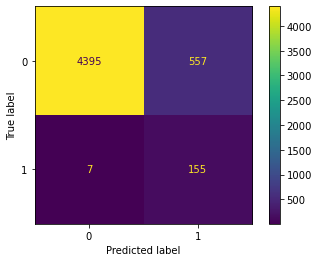

In [50]:
plot_confusion_matrix(gs_tree_2, X_train, y_train)

In [51]:
y_pred = gs_tree_2.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94      4952
           1       0.22      0.96      0.35       162

    accuracy                           0.89      5114
   macro avg       0.61      0.92      0.65      5114
weighted avg       0.97      0.89      0.92      5114



#### Decision Tree #2: Test Data

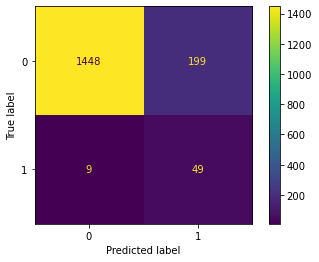

In [52]:
plot_confusion_matrix(gs_tree_2, X_test, y_test)
plt.savefig('images/gs_tree_2_confusion.png')
plt.show()

In [53]:
y_pred = gs_tree_2.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.88      0.93      1647
           1       0.20      0.84      0.32        58

    accuracy                           0.88      1705
   macro avg       0.60      0.86      0.63      1705
weighted avg       0.97      0.88      0.91      1705



This model both has a significantly improved f1 score compared to the simple decision tree model and the larger number of leaves means that it has a larger number of probability thresholds, which is useful if we want to divide companies into a larger number of risk classes. Its performance on the testing data is not much worse than its performance on the training data, which means that there isn't significant overfitting.  

### Decision Tree #2: Probability Thresholds

Below, we can see the number of predictions at each probability threshold (where >0.5 predicts bankruptcy and <0.5 predicts no bankruptcy).

In [54]:
predictions = pd.DataFrame(gs_tree_2.predict_proba(X_test), columns=['no bankruptcy','bankruptcy'])
predictions['bankruptcy'].value_counts()

0.000000    1336
0.905867      51
0.971225      35
0.245391      33
0.379405      29
0.374754      24
0.550100      22
0.452403      20
0.598574      17
0.898278      16
0.897264      16
0.670821      16
0.326692      15
0.799483      14
0.678263      11
0.772543      10
0.813671      10
0.656416       8
0.930023       6
0.693655       6
0.983906       3
0.824646       3
0.964503       2
0.792574       2
Name: bankruptcy, dtype: int64

#### Decision Tree #2: First Five Rows

Here we see that our decision tree accurately classified the first five rows of data, with our single positive result given a bankruptcy probability of 90.6%.

In [55]:
dataframe=get_threshold_outcome_dataframe(gs_tree_2)
dataframe.head()

,probabilities,predictions,Bankrupt?
239,0.000000,1,0
2850,0.000000,0,0
2687,0.000000,0,0
6500,0.905867,1,1
2684,0.000000,0,0


#### Decision Tree #2: 0.00% probability threshold

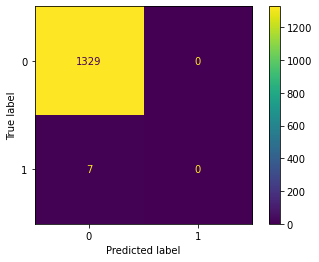

In [56]:
lowest_threshold_indices = get_indices_at_threshold(model=gs_tree_2, threshold=0.245391, above_thresh=False)

plot_confusion_matrix(gs_tree_2, X_test.loc[lowest_threshold_indices,:], y_test[lowest_threshold_indices])

As we see here, if we invested solely in stocks below the 0% bankruptcy probability threshold, we would have lost around 0.5% of their value to bankruptcies. This is a significant improvement compared to the 3% that we would have lost if we had invested randomly in the market.

#### Decision Tree #2: 50% precision

In [57]:
precision_recall_df=get_precision_recall_df(gs_tree_2)
precision_recall_df.loc[(precision_recall_df['precision']>0.40)&(precision_recall_df['precision']<0.70)]

,thresholds,recall,precision
20,0.930023,0.379310,0.478261
21,0.964503,0.310345,0.450000
22,0.971225,0.310345,0.473684
23,0.983906,0.034483,0.666667


As we can see here, we only reach >50% precision above the 98.4% probability threshold.

#### Decision Tree #2:  98.4% probability threshold

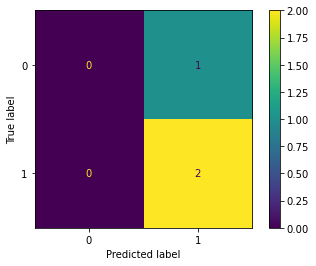

In [58]:
highest_threshold_indices = get_indices_at_threshold(model=gs_tree_2, threshold=0.98)

plot_confusion_matrix(gs_tree_2, X_test.loc[highest_threshold_indices,:], y_test[highest_threshold_indices])

Conversely, if we had shorted the stocks of companies with bankruptcy probabilities of the highest threshold (>98.4%), two out of three would have in fact gone bankrupt.

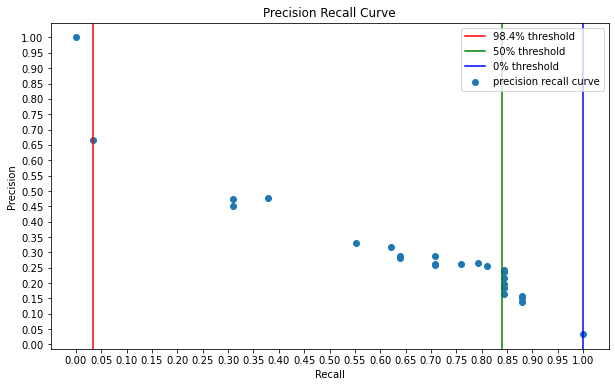

In [59]:
y_probs = [n[1] for n in gs_tree_2.predict_proba(X_test)]

precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(recall, precision, label='precision recall curve')

ax.set_yticks([i/20.0 for i in range(21)])
ax.set_xticks([i/20.0 for i in range(21)])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision Recall Curve')
ax.axvline(x=2/58, label='98.4% threshold', color='red')
ax.axvline(x=0.84, label='50% threshold', color='green')
ax.axvline(x=1, label='0% threshold', color='blue')
plt.legend(loc='upper right')
plt.savefig('images/dt_2_curve.png')
plt.show()

While this model does a good job reducing bankruptcies by filtering out companies above the 50% probability threshold, it doesn't do very well at picking out bankruptcies with precision. Only at the 98.4% threshold are we able to pick out a set of companies that are mostly bankruptcies. At this threshold we have two true positives and a false positive. Because the number of predicted bankruptices past this threshold is so small, we have very little reason to be confident in our 67% precision value and should not use this model for developing a short strategy.

## Random Forest Classifier

A random forest classifier uses multiple decision trees each trained on different randomly selected samples of the training data, and limited to a different set of randomly chosen features. Then the classifier  labels each data point according to the value predicted by the largest number of trees.

In [60]:
rfc = RandomForestClassifier(class_weight='balanced', random_state=42)

grid = [{'criterion': ['entropy', 'gini'],
        'n_estimators': [30, 40, 50],
        'max_depth': [2, 3, 4],
        'max_features': ['auto','log2']}]

gs_rfc = GridSearchCV(estimator=rfc, param_grid=grid, scoring='f1', cv=5)

In [61]:
gs_rfc.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             param_grid=[{'criterion': ['entropy', 'gini'],
                          'max_depth': [2, 3, 4],
                          'max_features': ['auto', 'log2'],
                          'n_estimators': [30, 40, 50]}],
             scoring='f1')

In [62]:
gs_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 4,
 'max_features': 'auto',
 'n_estimators': 40}

#### Random Forest Results - Training Data

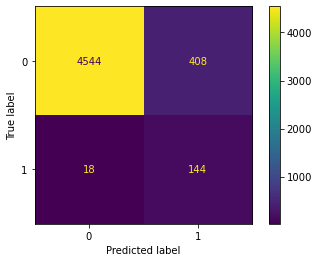

In [63]:
plot_confusion_matrix(gs_rfc, X_train, y_train)
plt.show()

In [64]:
y_pred = gs_rfc.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96      4952
           1       0.26      0.89      0.40       162

    accuracy                           0.92      5114
   macro avg       0.63      0.90      0.68      5114
weighted avg       0.97      0.92      0.94      5114



#### Random Forest Results - Test Data

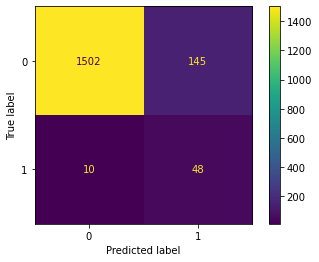

In [65]:
plot_confusion_matrix(gs_rfc, X_test, y_test)
plt.savefig('images/rfc_confusion.png')
plt.show()

In [66]:
y_pred = gs_rfc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.91      0.95      1647
           1       0.25      0.83      0.38        58

    accuracy                           0.91      1705
   macro avg       0.62      0.87      0.67      1705
weighted avg       0.97      0.91      0.93      1705



The random forest model performs slightly better than our second decision tree model at the 50% probabiility threshold, with an f1 score of 0.38 up from 0.32. This is mainly the result of better precision at this level--0.25, up from 0.2. However, the real test of this model is its ability to pick out a sizable high precision set of bankruptcies. Currently, the Logistic Regression Model is the only model that successfully does this, picking out 9 true positives to 1 false positive at the 99.9% probability threshold.

### Random Forest Probability Thresholds

Below are value counts for all of the predicted probabilities produced by our random forest algorithm on our test data. As we can see the most common value is the smallest--presumably probability values of 0.000494 correspond to the vote of only one decision tree in our random forest. 

In [67]:
predictions = pd.DataFrame(gs_rfc.predict_proba(X_test), columns=['no bankruptcy','bankruptcy'])
predictions['bankruptcy'].value_counts()

0.000494    196
0.001812     79
0.002246     77
0.003593     22
0.003564     16
           ... 
0.022407      1
0.006010      1
0.168260      1
0.157549      1
0.033026      1
Name: bankruptcy, Length: 1202, dtype: int64

#### Precision at >94% threshold

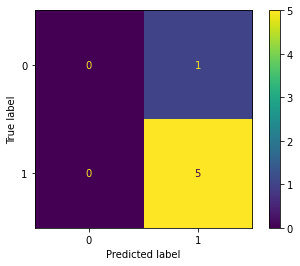

In [76]:
highest_threshold_indices = get_indices_at_threshold(model=gs_rfc, threshold=0.94)

plot_confusion_matrix(gs_rfc, X_test.loc[highest_threshold_indices,:], y_test[highest_threshold_indices])

#### Precision at <6% threshold

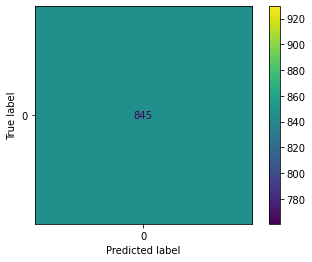

In [70]:
lowest_threshold_indices = get_indices_at_threshold(model=gs_rfc, threshold=0.06, above_thresh=False)

plot_confusion_matrix(gs_rfc, X_test.loc[lowest_threshold_indices,:], y_test[lowest_threshold_indices])

#### Values at which we see 50% precision

In [71]:
precision_recall_df=get_precision_recall_df(gs_rfc)
precision_recall_df.loc[(precision_recall_df['precision']>0.499)&(precision_recall_df['precision']<0.501)]

,thresholds,recall,precision
814,0.877738,0.310345,0.5
816,0.883500,0.293103,0.5
818,0.886218,0.275862,0.5
822,0.907370,0.241379,0.5
826,0.914734,0.206897,0.5
832,0.917741,0.155172,0.5
834,0.919585,0.137931,0.5
836,0.924378,0.120690,0.5
838,0.926928,0.103448,0.5


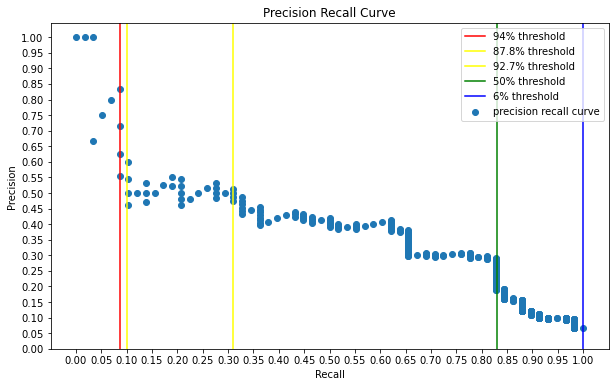

In [77]:
#getting probabilities for decision function

y_probs = [n[1] for n in gs_rfc.predict_proba(X_test)]

# getting precision recall curve

precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(recall, precision, label='precision recall curve')

ax.set_yticks([i/20.0 for i in range(21)])
ax.set_xticks([i/20.0 for i in range(21)])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision Recall Curve')
ax.axvline(x=5/58, label='94% threshold', color='red')
ax.axvline(x=0.31, label= '87.8% threshold', color='yellow')
ax.axvline(x=0.1, label='92.7% threshold', color='yellow')
ax.axvline(x=0.83, label='50% threshold', color='green')
ax.axvline(x=1, label='6% threshold', color='blue')

plt.legend(loc='upper right')

plt.savefig('images/rfc_curve.png')
plt.show()

Despite this model's superior F1 score, it performs worse than Logistic Regression at picking out bankruptcies. Above the 94% probabiility threshold, it picked out 1 false positive to five true positives. Below this threshold, our precision quickly drops down to 50%. While the Logistic regression model also drops down to 50% precision around the 94% probability threshold, this takes place farther along the curve, when the recall is around 0.4. In contrast, the Random Forest drops to 50% precision when the recall is only 0.1.

## XGBoost

The last algorithm I tested was XGBoost, which uses a succession of weak learner tree algorithms that train on their predecessor's weaknesses to make a progressively stronger predictions. 

In [78]:
from xgboost import XGBClassifier

In [79]:
grid = {
    'max_depth': [2, 3, 4],
    'n_estimators': [20, 40, 60],
    'min_child_weight': [0.002, 0.02, 0.2],
    'reg_lambda': [2**n for n in range(5, 8)]
}

ratio = y_train.value_counts()[0]/y_train.value_counts()[1]

xgb_clf = XGBClassifier(use_label_encoder=False, random_state=42, eval_metric='logloss', scale_pos_weight=ratio)

gs_xgb = GridSearchCV(estimator=xgb_clf, param_grid=grid, cv=5, scoring='f1')

In [80]:
gs_xgb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, mono...
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, reg_alpha=None,
                                     reg_lambda=None,
                                     scale_po

In [81]:
gs_xgb.best_params_

{'max_depth': 4, 'min_child_weight': 0.2, 'n_estimators': 60, 'reg_lambda': 64}

#### XGBoost Results - Training Data

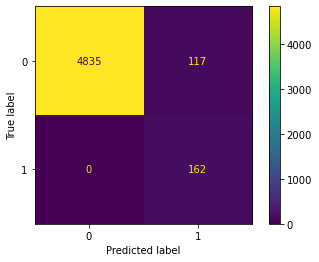

In [82]:
plot_confusion_matrix(gs_xgb, X_train, y_train)
plt.show()

In [83]:
y_pred = gs_xgb.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      4952
           1       0.58      1.00      0.73       162

    accuracy                           0.98      5114
   macro avg       0.79      0.99      0.86      5114
weighted avg       0.99      0.98      0.98      5114



#### XGBoost Results - Testing Data

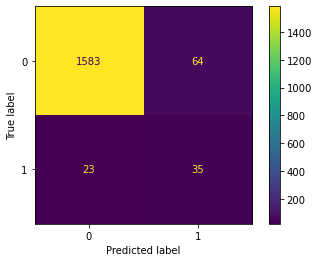

In [84]:
plot_confusion_matrix(gs_xgb, X_test, y_test)
plt.savefig('images/xgb_confusion.png')

In [87]:
y_pred = gs_xgb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1647
           1       0.35      0.60      0.45        58

    accuracy                           0.95      1705
   macro avg       0.67      0.78      0.71      1705
weighted avg       0.96      0.95      0.96      1705



This model has the best F1 Score so far: 0.45, which was achieved by sacrificing recall for precision at the 50% probability threshold. 99% precision for non-bankruptcies means that are model continues to work well for assembling a low-risk portfolio.

How precise is it for high values? Can it beat logistic regression?

#### 97% Probability Threshold

At this 97% probability threshold the model picks out 5 true positives to one false positive. This compares poorly with the 99.9% threshold for the linear regression model, which was able to pick out 9 true positives to one false positive.

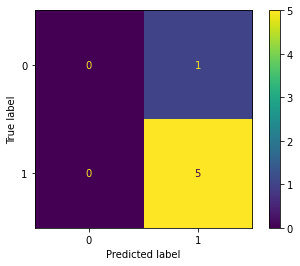

In [88]:
highest_threshold_indices = get_indices_at_threshold(model=gs_xgb, threshold=0.97)

plot_confusion_matrix(gs_xgb, X_test.loc[highest_threshold_indices,:], y_test[highest_threshold_indices])
plt.show()

### Precision Recall Curve

If we examine the precision recall curve below, we can see that the model is able to pick out three true positives at the very highest thresholds,  then quickly dips and stays consistently between 60 and 70% precision before descending quickly to 55% precision when we hit 35% recall.

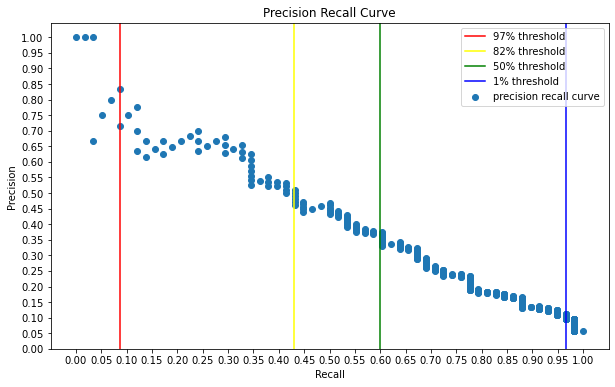

In [95]:
#getting probabilities for decision function

y_probs = [n[1] for n in gs_xgb.predict_proba(X_test)]

# getting precision recall curve

precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(recall, precision, label='precision recall curve')

ax.set_yticks([i/20.0 for i in range(21)])
ax.set_xticks([i/20.0 for i in range(21)])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision Recall Curve')
ax.axvline(x=5/58, label='97% threshold', color='red')
ax.axvline(x=0.43, label='82% threshold', color='yellow')
ax.axvline(x=0.6, label='50% threshold', color='green')
ax.axvline(x=56/58, label='1% threshold', color='blue')

plt.legend(loc='upper right')
plt.savefig('images/xgb_curve.png')
plt.show()

How do we adjudicate between this model and our logistic regression model. The logistic regression model is most impressive insofar as its 99.9% threshold is able to pick out 9 bankruptcies and only one false positive. However, its high variance below this threshold is alarming, since precision drops down to 55% when recall hits 20% before rising again.

XGBoost on the other hand, maintains a precision of over 60% until recall hits 35%, which means that its performance is more dependable if also more lackluster.

## Conclusion

With an f1 score of 45%, XGBoost is probably our best model, though even with regularization and a conservative choice of hyperparameters, it appears to be overfitting somewhat on the data. While it's not able to achieve the extremely high probability predictions of Logistic Regression it's able to find more bankruptcies with fewer overall errors. This is valuable, because companies with extremely high bankruptcy probabilities have likely already been identified by the market and their risk of bankruptcy has probably been priced in. By balancing recall and precision, XGBoost may be the best tool for investors who think they can make a profit by predicting bankruptcies with a reliable 65% precision rate.

## Limitations and Further Analysis

The biggest limitation of this study is that that small changes in probability threshold can result in large changes in precision scores. We sometimes see precipituous dips in precision as new false positives fall above the probability threshold followed by rises in precision as more true positives are included. This is especially a problem at high probability thresholds since, at these thresholds, we have the fewest data points, making the curve more sensitive to individual false positives.

The best way to deal with this problem would be to use a smoothing function that would convert our current precision values to an average of nearby values, along with a variance function that identifies the variance of empirical precision values relative to the smoothing function. This would lower our predicted precision values to a more conservative level and would also quantify the amount of risk associated with predicting above bankruptcies a given probability threshold. 